In [2]:
# See Hierarchical Binominal Model: Rat Tumor Example
# https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.distributions.transforms as tr
import seaborn as sns
import theano.tensor as tt

from scipy.special import gammaln

print('Running on PyMC3 v{}'.format(pm.__version__))


Running on PyMC3 v3.9.3


In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [4]:
# rat data (BDA3, p. 102)
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)

In [5]:
# Compute on log scale because products turn to sums
def log_likelihood(alpha, beta, y, n):
    LL = 0

    # Summing over data
    for Y, N in zip(y, n):
        LL += gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta) + \
            gammaln(alpha+Y) + gammaln(beta+N-Y) - gammaln(alpha+beta+N)

    return LL


def log_prior(A, B):

    return -5/2*np.log(A+B)


def trans_to_beta(x, y):

    return np.exp(y)/(np.exp(x)+1)


def trans_to_alpha(x, y):

    return np.exp(x)*trans_to_beta(x, y)


# Create space for the parameterization in which we wish to plot
X, Z = np.meshgrid(np.arange(-2.3, -1.3, 0.01), np.arange(1, 5, 0.01))
param_space = np.c_[X.ravel(), Z.ravel()]
df = pd.DataFrame(param_space, columns=['X', 'Z'])

# Transform the space back to alpha beta to compute the log-posterior
df['alpha'] = trans_to_alpha(df.X, df.Z)
df['beta'] = trans_to_beta(df.X, df.Z)

df['log_posterior'] = log_prior(
    df.alpha, df.beta) + log_likelihood(df.alpha, df.beta, y, n)
df['log_jacobian'] = np.log(df.alpha) + np.log(df.beta)

df['transformed'] = df.log_posterior+df.log_jacobian
df['exp_trans'] = np.exp(df.transformed - df.transformed.max())

# This will ensure the density is normalized
df['normed_exp_trans'] = df.exp_trans/df.exp_trans.sum()


surface = df.set_index(['X', 'Z']).exp_trans.unstack().values.T

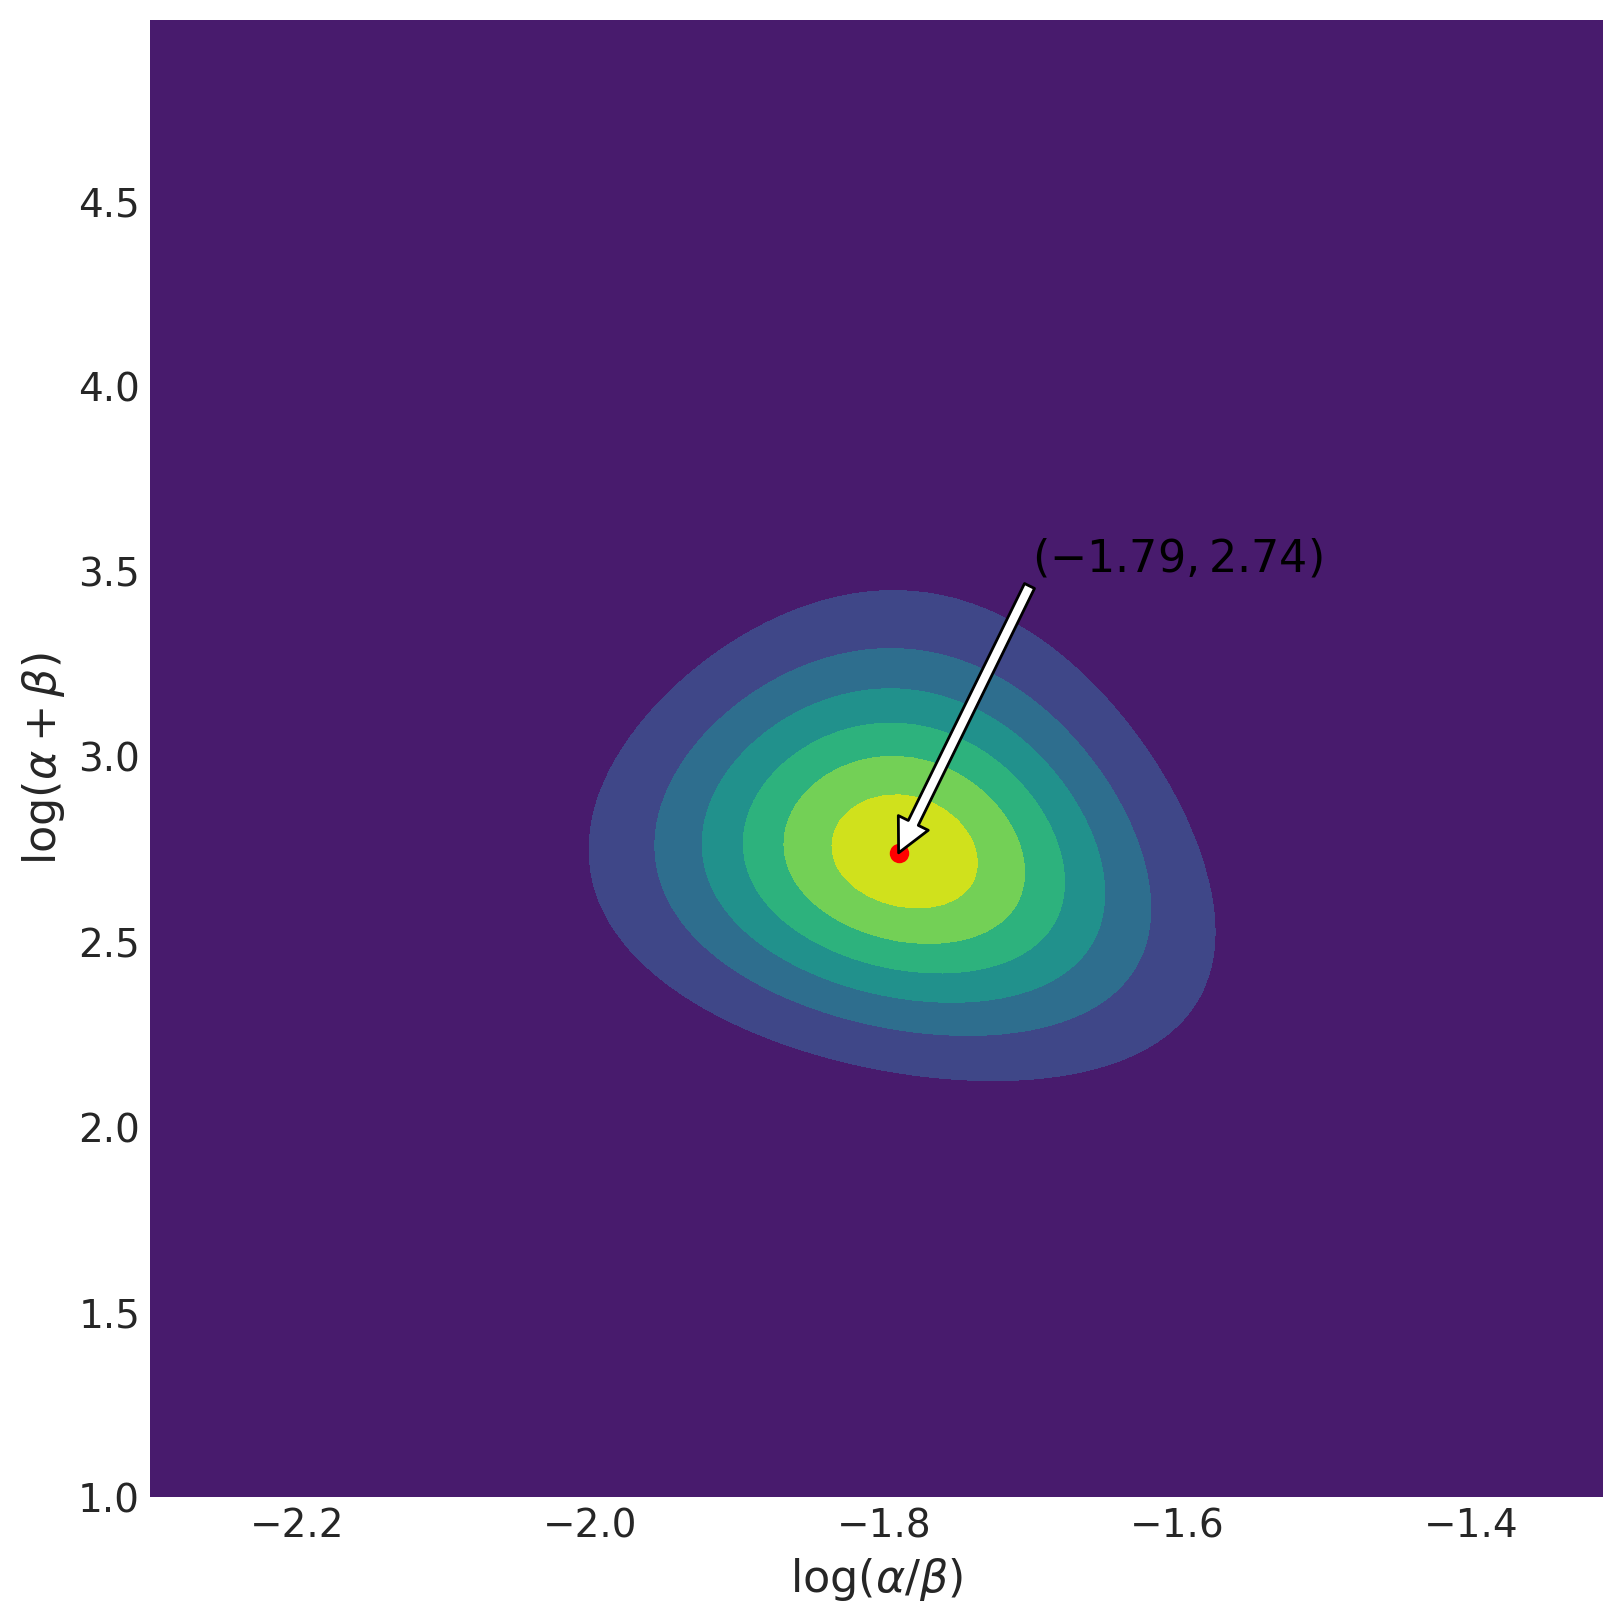

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(X, Z, surface)
ax.set_xlabel(r'$\log(\alpha/\beta)$', fontsize=16)
ax.set_ylabel(r'$\log(\alpha+\beta)$', fontsize=16)

ix_z, ix_x = np.unravel_index(np.argmax(surface, axis=None), surface.shape)
ax.scatter([X[0, ix_x]], [Z[ix_z, 0]], color='red')

text = r"$({a},{b})$".format(a=np.round(
    X[0, ix_x], 2), b=np.round(Z[ix_z, 0], 2))

ax.annotate(text,
            xy=(X[0, ix_x], Z[ix_z, 0]),
            xytext=(-1.6, 3.5),
            ha='center',
            fontsize=16,
            color='black',
            arrowprops={'facecolor':'white'}
            );

In [7]:
#Estimated mean of alpha
(df.alpha*df.normed_exp_trans).sum().round(3)

2.403

In [8]:
#Estimated mean of beta
(df.beta*df.normed_exp_trans).sum().round(3)

14.319

In [9]:
#Posterior with pymc3

def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab',
                     shape=2,
                     testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))

    X = pm.Deterministic('X', tt.log(ab[0]/ab[1]))
    Z = pm.Deterministic('Z', tt.log(tt.sum(ab)))

    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape=N)

    p = pm.Binomial('y', p=theta, observed=y, n=n)
    trace = pm.sample(1000, tune=2000, cores = 8, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, ab]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


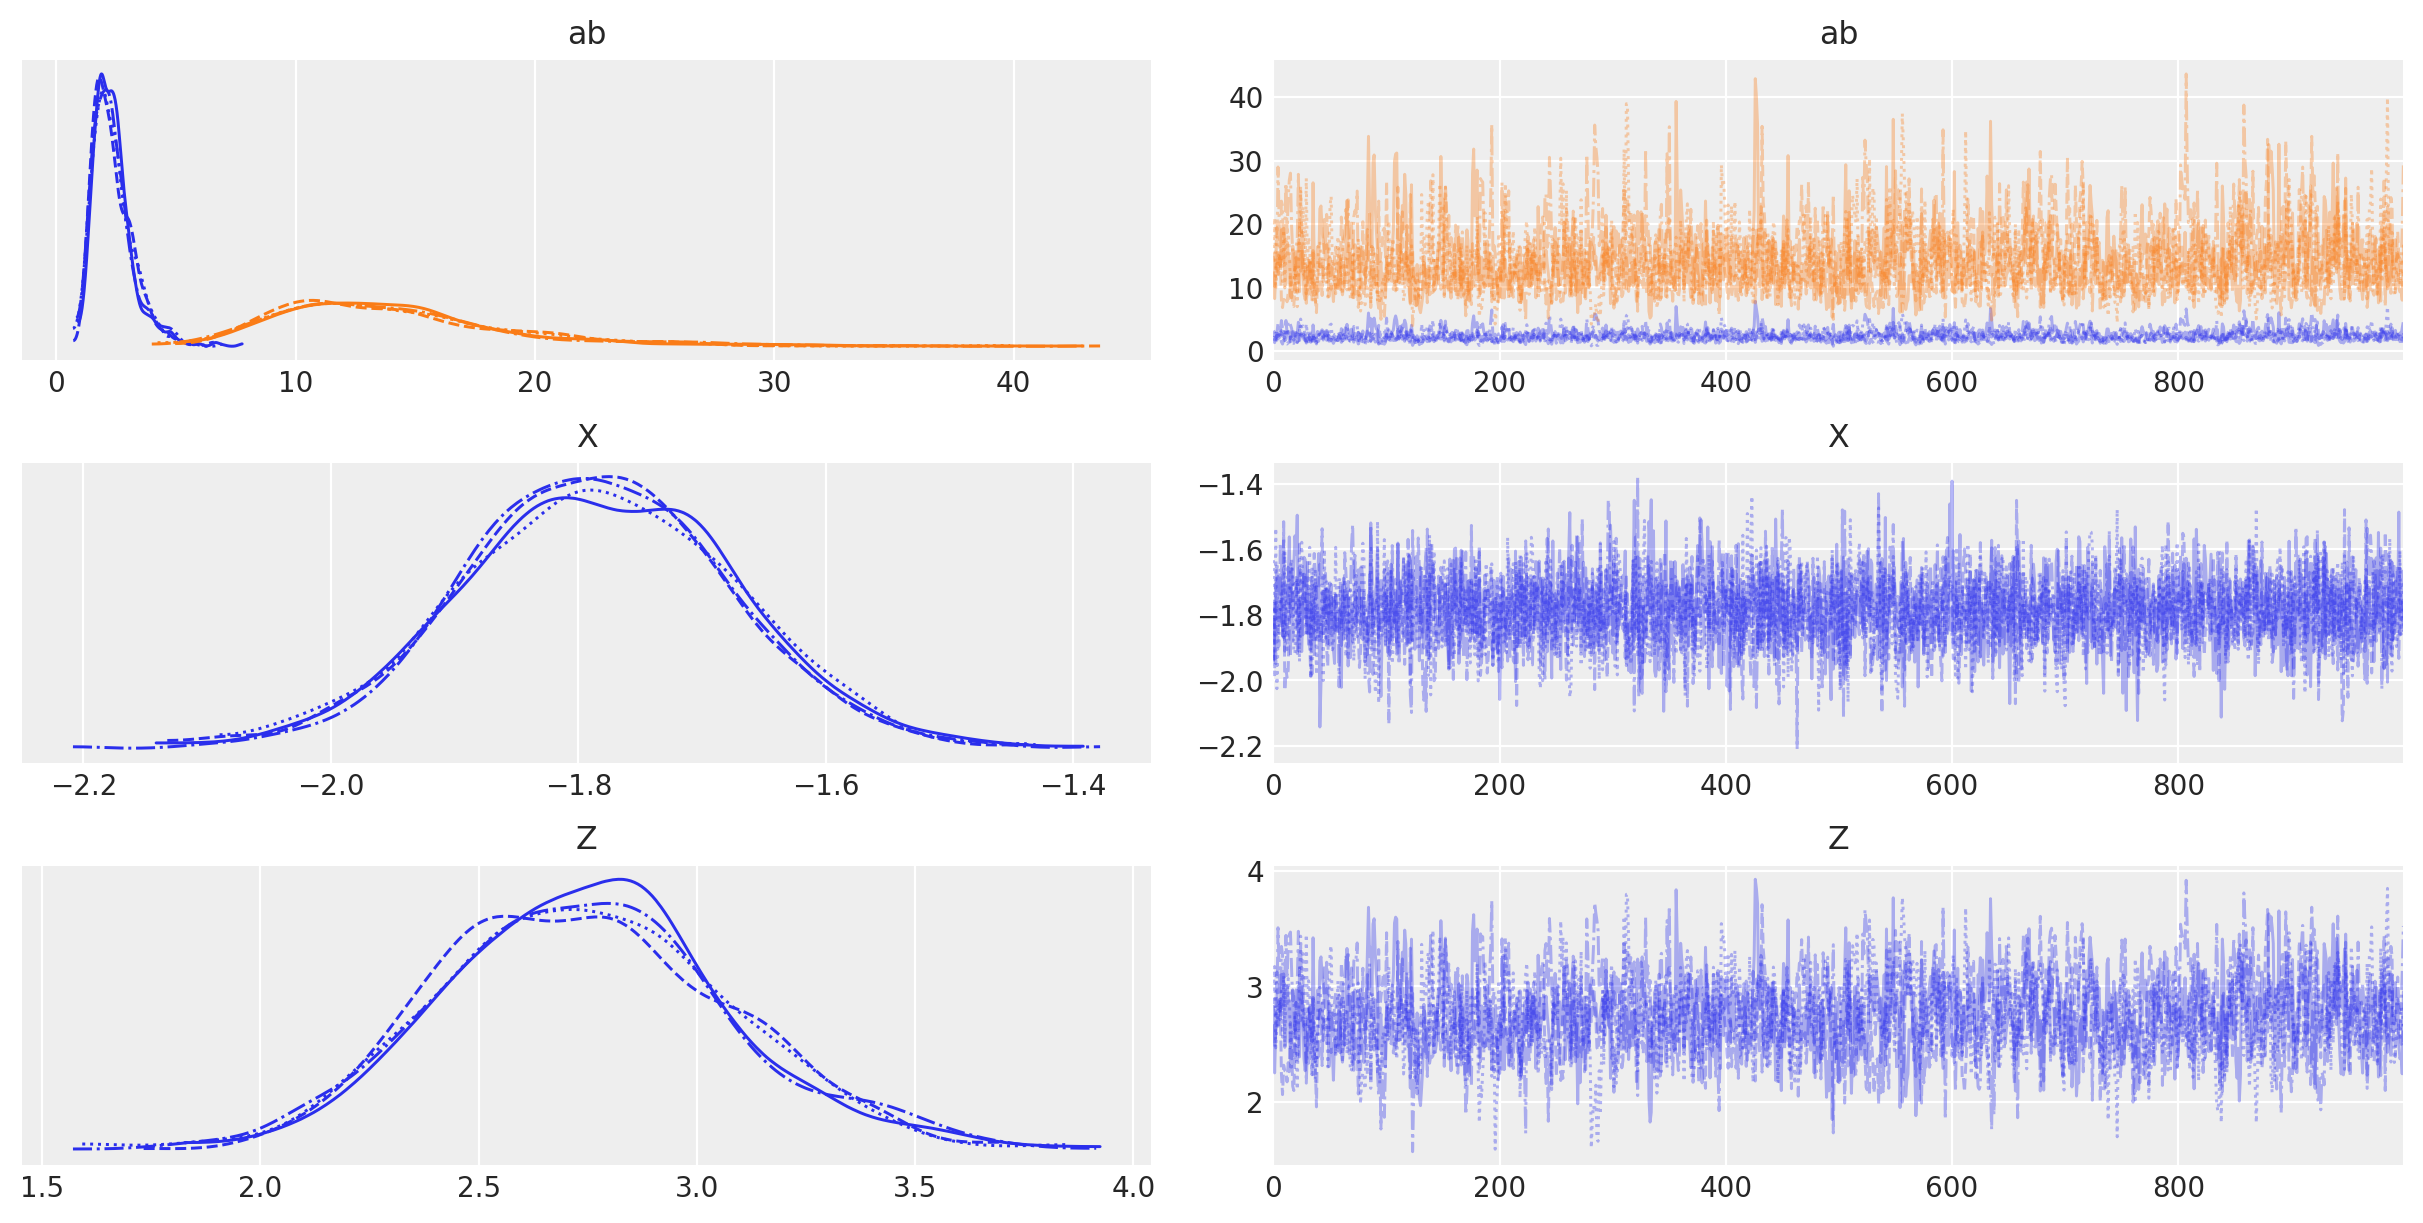

In [10]:
# Check the trace plots
with pm.Model() as model:
    pm.traceplot(trace, var_names=['ab', 'X', 'Z']);

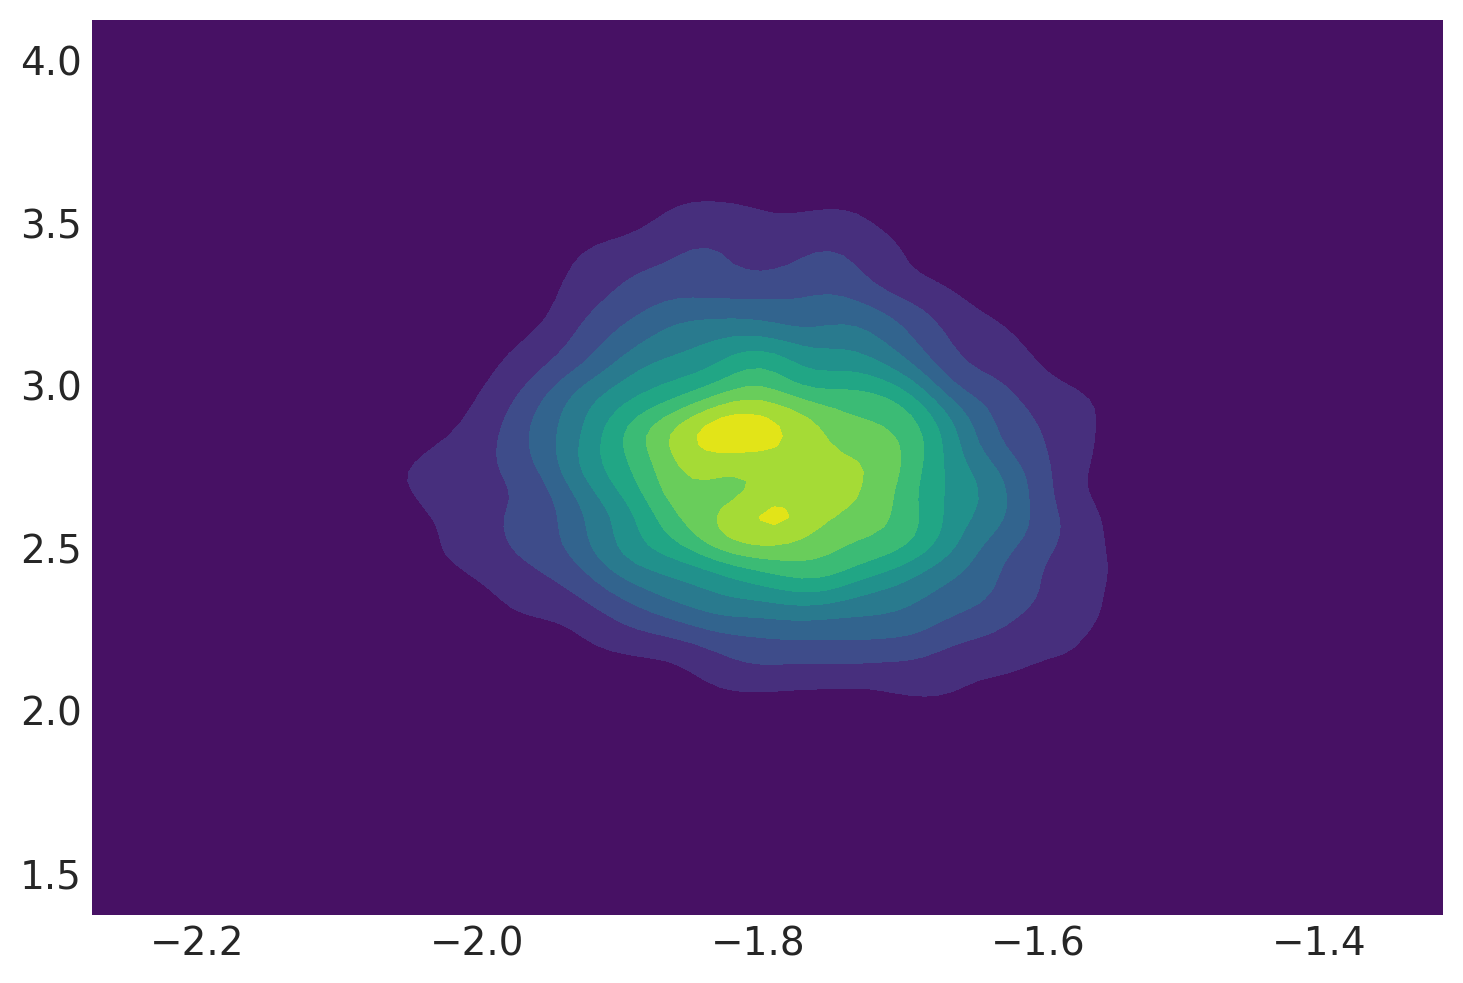

In [11]:
sns.kdeplot(trace['X'], trace['Z'], shade=True, cmap='viridis');

In [12]:
# estimate the means from the samples
trace['ab'].mean(axis=0)

array([ 2.35930565, 14.07259127])